##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 数据增强

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/tutorials/images/data_augmentation"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/images/data_augmentation.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/images/data_augmentation.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/images/data_augmentation.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

## 概述

本教程演示了数据增强：一种通过应用随机（但真实）的变换（例如图像旋转）来增加训练集多样性的技术。

您将学习如何通过两种方式应用数据增强：

- 使用 Keras 预处理层，例如 `tf.keras.layers.Resizing`、`tf.keras.layers.Rescaling`、`tf.keras.layers.RandomFlip` 和 `tf.keras.layers.RandomRotation`。
- 使用 `tf.image` 方法，例如 `tf.image.flip_left_right`、`tf.image.rgb_to_grayscale`、`tf.image.adjust_brightness`、`tf.image.central_crop` 和 `tf.image.stateless_random*`。

## 设置

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

2023-11-07 23:01:12.896693: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 23:01:12.896747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 23:01:12.898397: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 下载数据集

本教程使用 [tf_flowers](https://tensorflow.google.cn/datasets/catalog/tf_flowers) 数据集。为了方便起见，请使用 [TensorFlow Datasets](https://tensorflow.google.cn/datasets) 下载数据集。如果您想了解导入数据的其他方式，请参阅[加载图像](https://tensorflow.google.cn/tutorials/load_data/images)教程。


In [3]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

花卉数据集有五个类。

In [4]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


我们从数据集中检索一个图像，然后使用它来演示数据增强。

2023-11-07 23:01:19.803176: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


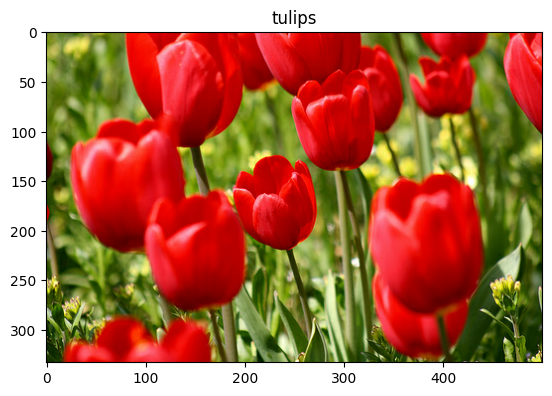

In [5]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## 使用 Keras 预处理层

### 调整大小和重新缩放


您可以使用 Keras 预处理层将图像大小调整为一致的形状（使用 `tf.keras.layers.Resizing`），并重新调整像素值（使用 `tf.keras.layers.Rescaling`）。

In [6]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

注：上面的重新缩放层将像素值标准化到 `[0,1]` 范围。如果想要 `[-1,1]`，可以编写 `tf.keras.layers.Rescaling(1./127.5, offset=-1)`。


您可以看到将这些层应用于图像的结果。 

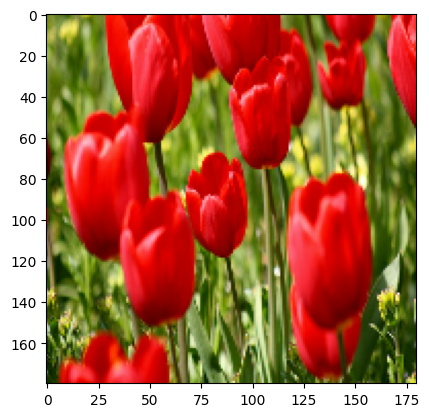

In [7]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

验证像素是否在 `[0, 1]` 范围内：

In [8]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### 数据增强

您也可以使用 Keras 预处理层进行数据增强，例如 `tf.keras.layers.RandomFlip` 和 `tf.keras.layers.RandomRotation`。

我们来创建一些预处理层，然后将它们重复应用于同一图像。

In [9]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [10]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

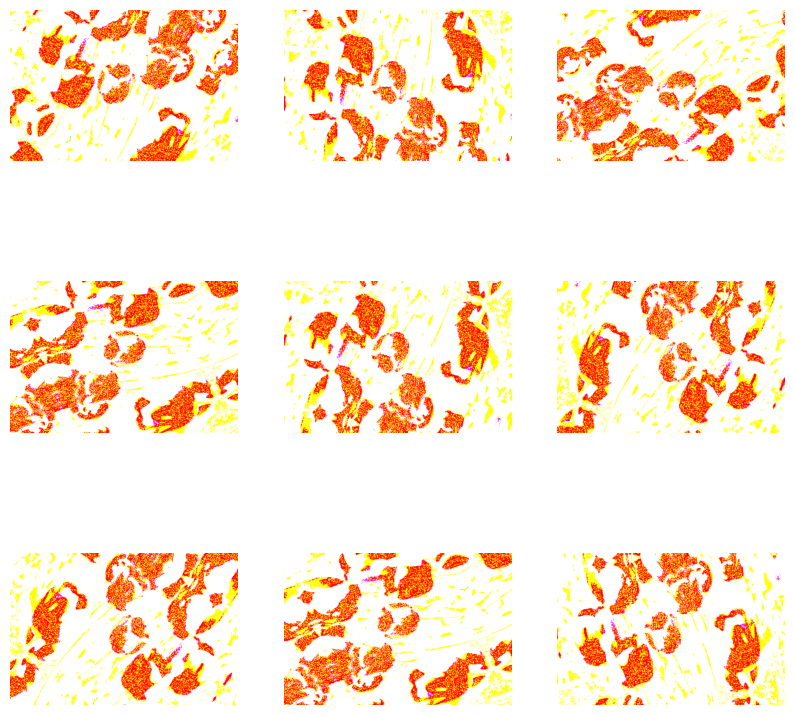

In [11]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

有多种预处理层可用于数据增强，包括 `tf.keras.layers.RandomContrast`、`tf.keras.layers.RandomCrop`、`tf.keras.layers.RandomZoom` 等。

### 使用 Keras 预处理层的两个选项

您可以通过两种方式使用这些预处理层，但需进行重要的权衡。

#### 选项 1：使预处理层成为模型的一部分

In [12]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])

在这种情况下，需要注意两个要点：

- 数据增强将与其他层在设备端同步运行，并受益于 GPU 加速。

- 当您使用 `model.save` 导出模型时，预处理层将与模型的其他部分一起保存。如果您稍后部署此模型，它将自动标准化图像（根据您的层配置）。这可以省去在服务器端重新实现该逻辑的工作。

注：数据增强在测试时处于停用状态，因此只有在调用 `Model.fit`（而非 `Model.evaluate` 或 `Model.predict`）期间才会对输入图像进行增强。

#### 选项 2：将预处理层应用于数据集

In [13]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

通过这种方式，您可以使用 `Dataset.map` 创建产生增强图像批次的数据集。在本例中：

- 数据增强将在 CPU 上异步进行，且为非阻塞性。您可以使用 `Dataset.prefetch` 将 GPU 上的模型训练与数据数据预处理重叠，如下所示。
- 在本例中，当您调用 `Model.save` 时，预处理层将不会随模型一起导出。在保存模型或在服务器端重新实现它们之前，您需要将它们附加到模型上。训练后，您可以在导出之前附加预处理层。


您可以在[图像分类](classification.ipynb)教程中找到第一个选项的示例。我们在这里演示一下第二个选项。

### 将预处理层应用于数据集

使用上面创建的 Keras 预处理层配置训练数据集、验证数据集和测试数据集。您还将配置数据集以提高性能，具体方式是使用并行读取和缓冲预提取从磁盘产生批次，这样不会阻塞 I/O。（您可以通过[使用 tf.data API 提高性能](https://tensorflow.google.cn/guide/data_performance)指南详细了解数据集性能）。

注：应仅对训练集应用数据增强。

In [14]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### 训练模型

为了完整起见，您现在将使用刚刚准备的数据集训练模型。

[序贯](https://tensorflow.google.cn/guide/keras/sequential_model)模型由三个卷积块 (`tf.keras.layers.Conv2D`) 组成，每个卷积块都有一个最大池化层 (`tf.keras.layers.MaxPooling2D`)。有一个全连接层 (`tf.keras.layers.Dense`)，上面有 128 个单元，由 ReLU 激活函数 (`'relu'`) 激活。此模型尚未针对准确率进行调整（目标是展示机制）。

In [16]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

选择 `tf.keras.optimizers.Adam` 优化器和 `tf.keras.losses.SparseCategoricalCrossentropy` 损失函数。要查看每个训练周期的训练和验证准确率，请将 `metrics` 参数传递给 `Model.compile`。

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

训练几个周期：

In [18]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


I0000 00:00:1699398085.777697  499426 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1/92 [..............................] - ETA: 7:48 - loss: 1.6154 - accuracy: 0.1250

 4/92 [>.............................] - ETA: 1s - loss: 2.6551 - accuracy: 0.1875  

 7/92 [=>............................] - ETA: 1s - loss: 2.2838 - accuracy: 0.1830

10/92 [==>...........................] - ETA: 1s - loss: 2.0839 - accuracy: 0.1781

13/92 [===>..........................] - ETA: 1s - loss: 1.9752 - accuracy: 0.1707

16/92 [====>.........................] - ETA: 1s - loss: 1.9056 - accuracy: 0.1895

19/92 [=====>........................] - ETA: 1s - loss: 1.8545 - accuracy: 0.1974

22/92 [======>.......................] - ETA: 1s - loss: 1.8233 - accuracy: 0.1918

25/92 [=======>......................] - ETA: 1s - loss: 1.7956 - accuracy: 0.1975

28/92 [========>.....................] - ETA: 1s - loss: 1.7745 - accuracy: 0.2031

31/92 [=========>....................] - ETA: 1s - loss: 1.7553 - accuracy: 0.2228

34/92 [==========>...................] - ETA: 1s - loss: 1.7374 - accuracy: 0.2243

37/92 [===========>..................] - ETA: 1s - loss: 1.7219 - accuracy: 0.2289

40/92 [============>.................] - ETA: 1s - loss: 1.7077 - accuracy: 0.2313

43/92 [=============>................] - ETA: 0s - loss: 1.6932 - accuracy: 0.2369

46/92 [==============>...............] - ETA: 0s - loss: 1.6795 - accuracy: 0.2486

49/92 [==============>...............] - ETA: 0s - loss: 1.6592 - accuracy: 0.2602

52/92 [===============>..............] - ETA: 0s - loss: 1.6501 - accuracy: 0.2650

55/92 [================>.............] - ETA: 0s - loss: 1.6302 - accuracy: 0.2744

58/92 [=================>............] - ETA: 0s - loss: 1.6128 - accuracy: 0.2818

61/92 [==================>...........] - ETA: 0s - loss: 1.5971 - accuracy: 0.2864

64/92 [===================>..........] - ETA: 0s - loss: 1.5828 - accuracy: 0.2925

67/92 [====================>.........] - ETA: 0s - loss: 1.5685 - accuracy: 0.3008

70/92 [=====================>........] - ETA: 0s - loss: 1.5547 - accuracy: 0.3094

73/92 [======================>.......] - ETA: 0s - loss: 1.5387 - accuracy: 0.3176

76/92 [=======================>......] - ETA: 0s - loss: 1.5205 - accuracy: 0.3269

79/92 [========================>.....] - ETA: 0s - loss: 1.5216 - accuracy: 0.3299

82/92 [=========================>....] - ETA: 0s - loss: 1.5162 - accuracy: 0.3327

85/92 [==========================>...] - ETA: 0s - loss: 1.5094 - accuracy: 0.3338

88/92 [===========================>..] - ETA: 0s - loss: 1.5008 - accuracy: 0.3388

91/92 [============================>.] - ETA: 0s - loss: 1.4911 - accuracy: 0.3431

92/92 [==============================] - ETA: 0s - loss: 1.4885 - accuracy: 0.3440

92/92 [==============================] - 9s 43ms/step - loss: 1.4885 - accuracy: 0.3440 - val_loss: 1.2572 - val_accuracy: 0.4659


Epoch 2/5


 1/92 [..............................] - ETA: 29s - loss: 1.1432 - accuracy: 0.6250

 2/92 [..............................] - ETA: 6s - loss: 1.2401 - accuracy: 0.4844 

 5/92 [>.............................] - ETA: 2s - loss: 1.2354 - accuracy: 0.5125

 8/92 [=>............................] - ETA: 2s - loss: 1.2556 - accuracy: 0.4805

11/92 [==>...........................] - ETA: 2s - loss: 1.2298 - accuracy: 0.4631

14/92 [===>..........................] - ETA: 1s - loss: 1.2104 - accuracy: 0.4732

17/92 [====>.........................] - ETA: 1s - loss: 1.1889 - accuracy: 0.4945

20/92 [=====>........................] - ETA: 1s - loss: 1.1714 - accuracy: 0.4969

23/92 [======>.......................] - ETA: 1s - loss: 1.1834 - accuracy: 0.4918

26/92 [=======>......................] - ETA: 1s - loss: 1.1857 - accuracy: 0.4976

29/92 [========>.....................] - ETA: 1s - loss: 1.1867 - accuracy: 0.4925

32/92 [=========>....................] - ETA: 1s - loss: 1.1758 - accuracy: 0.5020

35/92 [==========>...................] - ETA: 1s - loss: 1.1853 - accuracy: 0.5018

38/92 [===========>..................] - ETA: 1s - loss: 1.1840 - accuracy: 0.4992

41/92 [============>.................] - ETA: 1s - loss: 1.1839 - accuracy: 0.4985

44/92 [=============>................] - ETA: 1s - loss: 1.1783 - accuracy: 0.5043

47/92 [==============>...............] - ETA: 0s - loss: 1.1727 - accuracy: 0.5060

50/92 [===============>..............] - ETA: 0s - loss: 1.1757 - accuracy: 0.5038

53/92 [================>.............] - ETA: 0s - loss: 1.1707 - accuracy: 0.5053

56/92 [=================>............] - ETA: 0s - loss: 1.1664 - accuracy: 0.5089

59/92 [==================>...........] - ETA: 0s - loss: 1.1627 - accuracy: 0.5117

62/92 [===================>..........] - ETA: 0s - loss: 1.1642 - accuracy: 0.5076

65/92 [====================>.........] - ETA: 0s - loss: 1.1563 - accuracy: 0.5149

68/92 [=====================>........] - ETA: 0s - loss: 1.1553 - accuracy: 0.5170

71/92 [======================>.......] - ETA: 0s - loss: 1.1541 - accuracy: 0.5194

74/92 [=======================>......] - ETA: 0s - loss: 1.1528 - accuracy: 0.5220

77/92 [========================>.....] - ETA: 0s - loss: 1.1488 - accuracy: 0.5252

80/92 [=========================>....] - ETA: 0s - loss: 1.1471 - accuracy: 0.5258

83/92 [==========================>...] - ETA: 0s - loss: 1.1445 - accuracy: 0.5279

86/92 [===========================>..] - ETA: 0s - loss: 1.1360 - accuracy: 0.5312

89/92 [============================>.] - ETA: 0s - loss: 1.1361 - accuracy: 0.5312

92/92 [==============================] - ETA: 0s - loss: 1.1319 - accuracy: 0.5317

92/92 [==============================] - 2s 21ms/step - loss: 1.1319 - accuracy: 0.5317 - val_loss: 1.0627 - val_accuracy: 0.5777


Epoch 3/5


 1/92 [..............................] - ETA: 27s - loss: 1.2052 - accuracy: 0.4375

 4/92 [>.............................] - ETA: 1s - loss: 1.0896 - accuracy: 0.5234 

 7/92 [=>............................] - ETA: 1s - loss: 1.0507 - accuracy: 0.5446

10/92 [==>...........................] - ETA: 1s - loss: 1.0424 - accuracy: 0.5375

13/92 [===>..........................] - ETA: 1s - loss: 1.0130 - accuracy: 0.5481

16/92 [====>.........................] - ETA: 1s - loss: 1.0167 - accuracy: 0.5527

19/92 [=====>........................] - ETA: 1s - loss: 1.0320 - accuracy: 0.5526

22/92 [======>.......................] - ETA: 1s - loss: 1.0408 - accuracy: 0.5526

25/92 [=======>......................] - ETA: 1s - loss: 1.0365 - accuracy: 0.5525

28/92 [========>.....................] - ETA: 1s - loss: 1.0302 - accuracy: 0.5580

31/92 [=========>....................] - ETA: 1s - loss: 1.0367 - accuracy: 0.5575

34/92 [==========>...................] - ETA: 1s - loss: 1.0241 - accuracy: 0.5643

37/92 [===========>..................] - ETA: 1s - loss: 1.0249 - accuracy: 0.5650

40/92 [============>.................] - ETA: 1s - loss: 1.0209 - accuracy: 0.5680

43/92 [=============>................] - ETA: 0s - loss: 1.0246 - accuracy: 0.5676

46/92 [==============>...............] - ETA: 0s - loss: 1.0322 - accuracy: 0.5652

49/92 [==============>...............] - ETA: 0s - loss: 1.0233 - accuracy: 0.5721

52/92 [===============>..............] - ETA: 0s - loss: 1.0187 - accuracy: 0.5727

55/92 [================>.............] - ETA: 0s - loss: 1.0189 - accuracy: 0.5750

58/92 [=================>............] - ETA: 0s - loss: 1.0193 - accuracy: 0.5776

61/92 [==================>...........] - ETA: 0s - loss: 1.0250 - accuracy: 0.5743

64/92 [===================>..........] - ETA: 0s - loss: 1.0228 - accuracy: 0.5771

67/92 [====================>.........] - ETA: 0s - loss: 1.0248 - accuracy: 0.5765

70/92 [=====================>........] - ETA: 0s - loss: 1.0240 - accuracy: 0.5781

73/92 [======================>.......] - ETA: 0s - loss: 1.0209 - accuracy: 0.5830

76/92 [=======================>......] - ETA: 0s - loss: 1.0179 - accuracy: 0.5835

79/92 [========================>.....] - ETA: 0s - loss: 1.0126 - accuracy: 0.5874

82/92 [=========================>....] - ETA: 0s - loss: 1.0146 - accuracy: 0.5857

85/92 [==========================>...] - ETA: 0s - loss: 1.0154 - accuracy: 0.5875

88/92 [===========================>..] - ETA: 0s - loss: 1.0158 - accuracy: 0.5874

91/92 [============================>.] - ETA: 0s - loss: 1.0099 - accuracy: 0.5900

92/92 [==============================] - 2s 21ms/step - loss: 1.0089 - accuracy: 0.5899 - val_loss: 0.9472 - val_accuracy: 0.6240


Epoch 4/5


 1/92 [..............................] - ETA: 30s - loss: 0.9641 - accuracy: 0.5625

 4/92 [>.............................] - ETA: 1s - loss: 0.9714 - accuracy: 0.6016 

 7/92 [=>............................] - ETA: 1s - loss: 0.9551 - accuracy: 0.5982

10/92 [==>...........................] - ETA: 1s - loss: 0.9959 - accuracy: 0.5875

13/92 [===>..........................] - ETA: 1s - loss: 0.9638 - accuracy: 0.6154

16/92 [====>.........................] - ETA: 1s - loss: 0.9778 - accuracy: 0.6074

19/92 [=====>........................] - ETA: 1s - loss: 0.9737 - accuracy: 0.6102

22/92 [======>.......................] - ETA: 1s - loss: 0.9700 - accuracy: 0.6122

25/92 [=======>......................] - ETA: 1s - loss: 0.9921 - accuracy: 0.6000

28/92 [========>.....................] - ETA: 1s - loss: 0.9870 - accuracy: 0.6049

31/92 [=========>....................] - ETA: 1s - loss: 0.9784 - accuracy: 0.6079

34/92 [==========>...................] - ETA: 1s - loss: 0.9747 - accuracy: 0.6140

37/92 [===========>..................] - ETA: 1s - loss: 0.9750 - accuracy: 0.6090

40/92 [============>.................] - ETA: 1s - loss: 0.9699 - accuracy: 0.6086

43/92 [=============>................] - ETA: 0s - loss: 0.9667 - accuracy: 0.6112

46/92 [==============>...............] - ETA: 0s - loss: 0.9607 - accuracy: 0.6128

49/92 [==============>...............] - ETA: 0s - loss: 0.9584 - accuracy: 0.6135

52/92 [===============>..............] - ETA: 0s - loss: 0.9592 - accuracy: 0.6130

55/92 [================>.............] - ETA: 0s - loss: 0.9628 - accuracy: 0.6136

58/92 [=================>............] - ETA: 0s - loss: 0.9547 - accuracy: 0.6169

61/92 [==================>...........] - ETA: 0s - loss: 0.9616 - accuracy: 0.6127

64/92 [===================>..........] - ETA: 0s - loss: 0.9648 - accuracy: 0.6128

67/92 [====================>.........] - ETA: 0s - loss: 0.9631 - accuracy: 0.6138

70/92 [=====================>........] - ETA: 0s - loss: 0.9601 - accuracy: 0.6147

73/92 [======================>.......] - ETA: 0s - loss: 0.9597 - accuracy: 0.6147

76/92 [=======================>......] - ETA: 0s - loss: 0.9560 - accuracy: 0.6147

79/92 [========================>.....] - ETA: 0s - loss: 0.9516 - accuracy: 0.6179

82/92 [=========================>....] - ETA: 0s - loss: 0.9466 - accuracy: 0.6189

85/92 [==========================>...] - ETA: 0s - loss: 0.9431 - accuracy: 0.6184

88/92 [===========================>..] - ETA: 0s - loss: 0.9440 - accuracy: 0.6190

91/92 [============================>.] - ETA: 0s - loss: 0.9459 - accuracy: 0.6171

92/92 [==============================] - 2s 22ms/step - loss: 0.9438 - accuracy: 0.6182 - val_loss: 1.0004 - val_accuracy: 0.6267


Epoch 5/5


 1/92 [..............................] - ETA: 26s - loss: 0.9598 - accuracy: 0.6875

 4/92 [>.............................] - ETA: 1s - loss: 0.9934 - accuracy: 0.6406 

 7/92 [=>............................] - ETA: 1s - loss: 1.0098 - accuracy: 0.6295

10/92 [==>...........................] - ETA: 1s - loss: 0.9773 - accuracy: 0.6375

13/92 [===>..........................] - ETA: 1s - loss: 0.9501 - accuracy: 0.6394

16/92 [====>.........................] - ETA: 1s - loss: 0.9380 - accuracy: 0.6484

19/92 [=====>........................] - ETA: 1s - loss: 0.9334 - accuracy: 0.6480

22/92 [======>.......................] - ETA: 1s - loss: 0.9279 - accuracy: 0.6435

25/92 [=======>......................] - ETA: 1s - loss: 0.9433 - accuracy: 0.6350

28/92 [========>.....................] - ETA: 1s - loss: 0.9250 - accuracy: 0.6406

31/92 [=========>....................] - ETA: 1s - loss: 0.9258 - accuracy: 0.6452

34/92 [==========>...................] - ETA: 1s - loss: 0.9149 - accuracy: 0.6480

37/92 [===========>..................] - ETA: 1s - loss: 0.9083 - accuracy: 0.6478

40/92 [============>.................] - ETA: 1s - loss: 0.9108 - accuracy: 0.6438

43/92 [=============>................] - ETA: 0s - loss: 0.9173 - accuracy: 0.6388

46/92 [==============>...............] - ETA: 0s - loss: 0.9131 - accuracy: 0.6420

49/92 [==============>...............] - ETA: 0s - loss: 0.9226 - accuracy: 0.6371

52/92 [===============>..............] - ETA: 0s - loss: 0.9234 - accuracy: 0.6358

55/92 [================>.............] - ETA: 0s - loss: 0.9176 - accuracy: 0.6375

58/92 [=================>............] - ETA: 0s - loss: 0.9123 - accuracy: 0.6417

61/92 [==================>...........] - ETA: 0s - loss: 0.9084 - accuracy: 0.6445

64/92 [===================>..........] - ETA: 0s - loss: 0.9021 - accuracy: 0.6479

67/92 [====================>.........] - ETA: 0s - loss: 0.8971 - accuracy: 0.6507

70/92 [=====================>........] - ETA: 0s - loss: 0.9012 - accuracy: 0.6500

73/92 [======================>.......] - ETA: 0s - loss: 0.9069 - accuracy: 0.6468

76/92 [=======================>......] - ETA: 0s - loss: 0.9018 - accuracy: 0.6472

79/92 [========================>.....] - ETA: 0s - loss: 0.9003 - accuracy: 0.6483

82/92 [=========================>....] - ETA: 0s - loss: 0.8929 - accuracy: 0.6524

85/92 [==========================>...] - ETA: 0s - loss: 0.8906 - accuracy: 0.6529

88/92 [===========================>..] - ETA: 0s - loss: 0.8874 - accuracy: 0.6548

91/92 [============================>.] - ETA: 0s - loss: 0.8890 - accuracy: 0.6538

92/92 [==============================] - 2s 20ms/step - loss: 0.8879 - accuracy: 0.6543 - val_loss: 0.9095 - val_accuracy: 0.6458


In [19]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

 1/12 [=>............................] - ETA: 22s - loss: 0.8560 - accuracy: 0.6250

 7/12 [================>.............] - ETA: 0s - loss: 0.7981 - accuracy: 0.6741 

12/12 [==============================] - 2s 9ms/step - loss: 0.8093 - accuracy: 0.6866


Accuracy 0.6866484880447388


### 自定义数据增强

您还可以创建自定义数据增强层。

教程的这一部分展示了两种操作方式：

- 首先，您将创建一个 `tf.keras.layers.Lambda` 层。这是编写简洁代码的好方式。
- 接下来，您将通过[子类化](https://tensorflow.google.cn/guide/keras/custom_layers_and_models)编写一个新层，这会给您更多的控制。

两个层都会根据某种概率随机反转图像中的颜色。

In [20]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [21]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

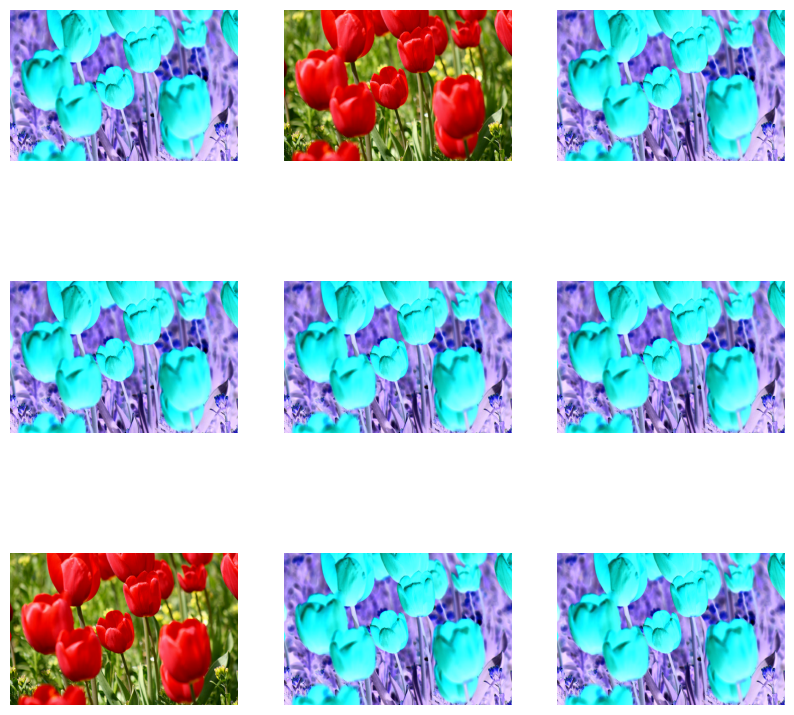

In [22]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

接下来，通过[子类化](https://tensorflow.google.cn/guide/keras/custom_layers_and_models)实现自定义层：

In [23]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

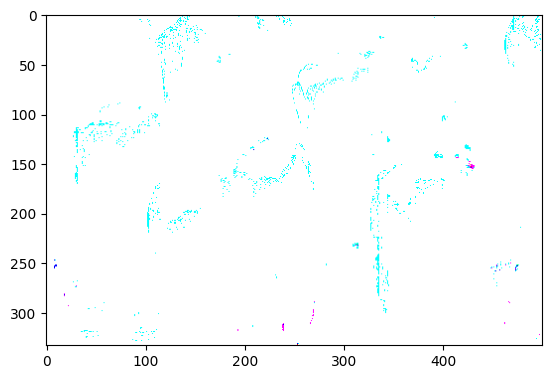

In [24]:
_ = plt.imshow(RandomInvert()(image)[0])

可以按照上述选项 1 和 2 中的描述使用这两个层。

## 使用 tf.image

上述 Keras 预训练实用工具十分方便。但为了更精细的控制，您可以使用 `tf.data` 和 <code>tf.image</code> 编写自己的数据增强流水线或数据增强层。您还可以查看 [TensorFlow Addons 图像：运算](https://tensorflow.google.cn/io/tutorials/colorspace)和 <a>TensorFlow I/O：色彩空间转换</a>。

由于花卉数据集之前已经配置了数据增强，因此我们将其重新导入以重新开始。

In [25]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

检索一个图像以供使用：

2023-11-07 23:01:45.778129: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


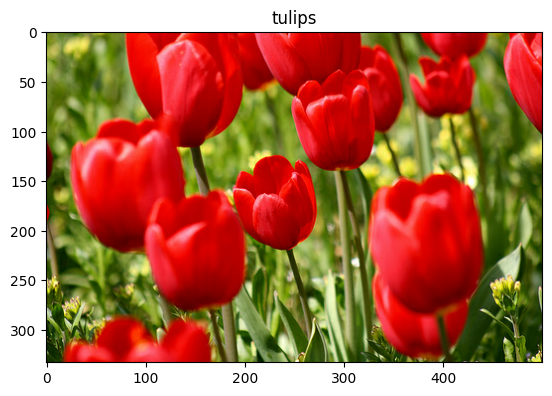

In [26]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

我们来使用以下函数呈现原始图像和增强图像，然后并排比较。

In [27]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

### 数据增强

#### 翻转图像

使用 `tf.image.flip_left_right` 垂直或水平翻转图像：

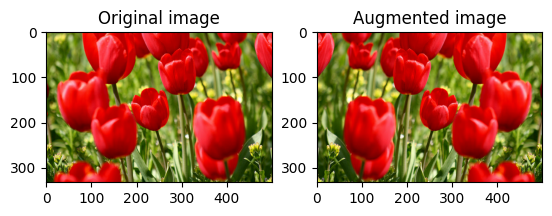

In [28]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

#### 对图像进行灰度处理

您可以使用 `tf.image.rgb_to_grayscale` 对图像进行灰度处理：

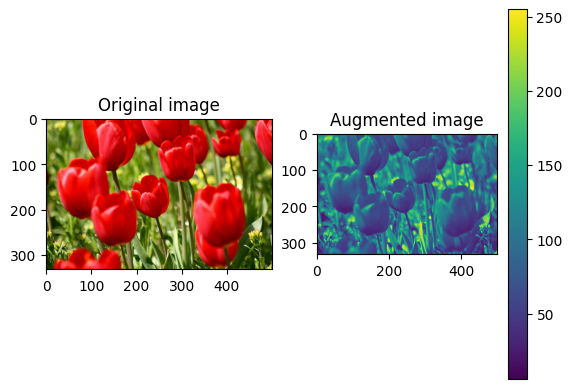

In [29]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

#### 调整图像饱和度

使用 `tf.image.adjust_saturation`，通过提供饱和度系数来调整图像饱和度：

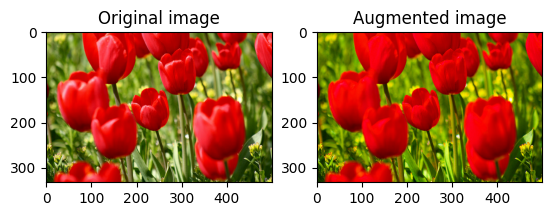

In [30]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

#### 更改图像亮度

使用 `tf.image.adjust_brightness`，通过提供亮度系数来更改图像的亮度：

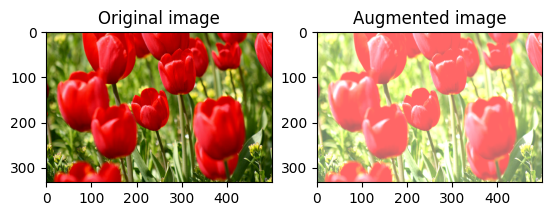

In [31]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

#### 对图像进行中心裁剪

使用 `tf.image.central_crop` 将图像从中心裁剪到所需部分：

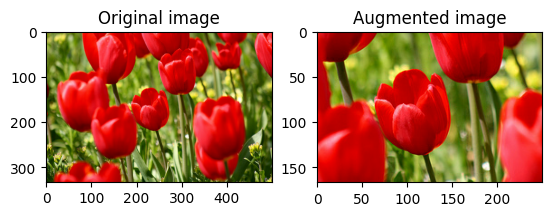

In [32]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

#### 旋转图像

使用 `tf.image.rot90` 将图像旋转 90 度：

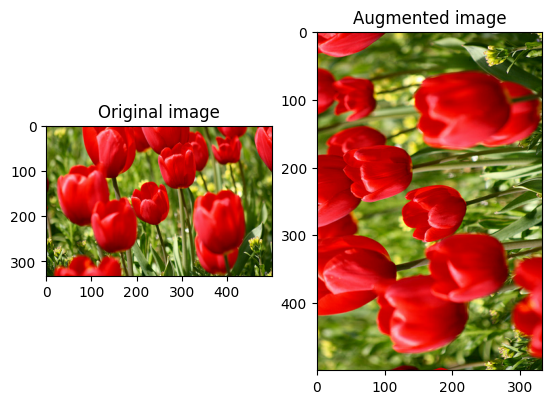

In [33]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

### 随机变换

警告：有两组随机图像运算：`tf.image.random*` 和 `tf.image.stateless_random*`。强烈不建议使用 `tf.image.random*` 运算，因为它们使用的是 TF 1.x 中的旧 RNG。请改用本教程中介绍的随机图像运算。有关详情，请参阅[随机数生成](../../guide/random_numbers.ipynb)。

对图像应用随机变换可以进一步帮助泛化和扩展数据集。当前的 `tf.image` API 提供了 8 个这样的随机图像运算 (op)：

- [`tf.image.stateless_random_brightness`](https://tensorflow.google.cn/api_docs/python/tf/image/stateless_random_brightness)
- [`tf.image.stateless_random_contrast`](https://tensorflow.google.cn/api_docs/python/tf/image/stateless_random_contrast)
- [`tf.image.stateless_random_crop`](https://tensorflow.google.cn/api_docs/python/tf/image/stateless_random_crop)
- [`tf.image.stateless_random_flip_left_right`](https://tensorflow.google.cn/api_docs/python/tf/image/stateless_random_flip_left_right)
- [`tf.image.stateless_random_flip_up_down`](https://tensorflow.google.cn/api_docs/python/tf/image/stateless_random_flip_up_down)
- [`tf.image.stateless_random_hue`](https://tensorflow.google.cn/api_docs/python/tf/image/stateless_random_hue)
- [`tf.image.stateless_random_jpeg_quality`](https://tensorflow.google.cn/api_docs/python/tf/image/stateless_random_jpeg_quality)
- [`tf.image.stateless_random_saturation`](https://tensorflow.google.cn/api_docs/python/tf/image/stateless_random_saturation)

这些随机图像运算纯粹是功能性的：输出仅取决于输入。这使得它们易于在高性能、确定性的输入流水线中使用。它们要求每一步都输入一个 `seed` 值。给定相同的 `seed`，无论被调用多少次，它们都会返回相同的结果。

注：`seed` 是形状为 `(2,)` 的 `Tensor`，其值为任意整数。

在以下部分中，您将：

1. 回顾使用随机图像运算来变换图像的示例。
2. 演示如何将随机变换应用于训练数据集。

#### 随机更改图像亮度

通过提供亮度系数和 `seed`，使用 `tf.image.stateless_random_brightness` 随机更改 `image` 的亮度。亮度系数在 `[-max_delta, max_delta)` 范围内随机选择，并与给定的 `seed` 相关联。

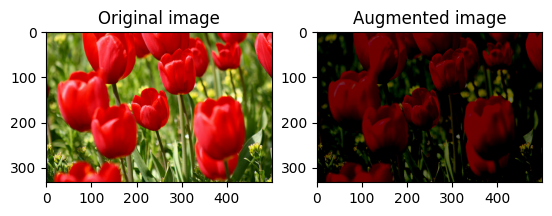

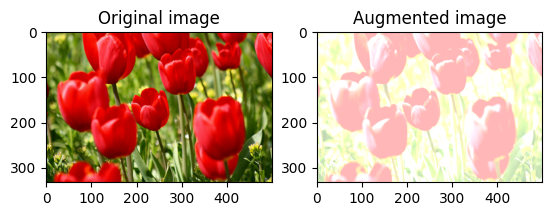

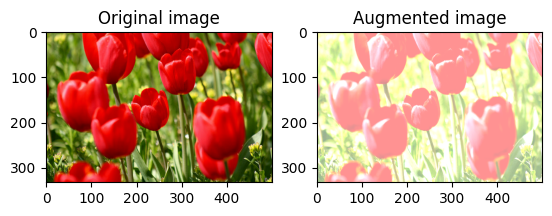

In [34]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

#### 随机更改图像对比度

通过提供对比度范围和 `seed`，使用 `tf.image.stateless_random_contrast` 随机更改 `image` 的对比度。对比度范围在区间 `[lower, upper]` 中随机选择，并与给定的 `seed` 相关联。

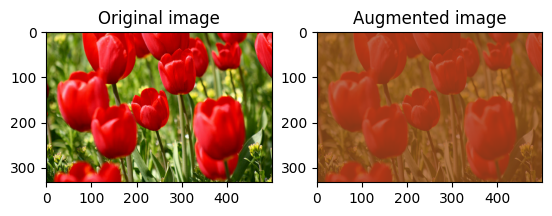

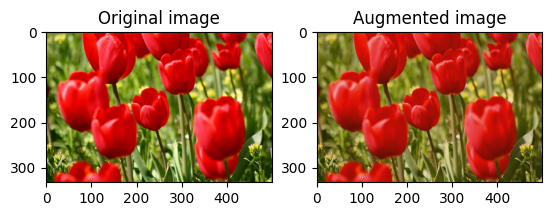

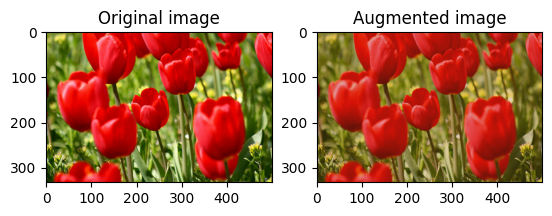

In [35]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_contrast = tf.image.stateless_random_contrast(
      image, lower=0.1, upper=0.9, seed=seed)
  visualize(image, stateless_random_contrast)

#### 随机裁剪图像

通过提供目标 `size` 和 `seed`，使用 `tf.image.stateless_random_crop` 随机裁剪 `image`。从 `image` 中裁剪出来的部分位于随机选择的偏移处，并与给定的 `seed` 相关联。

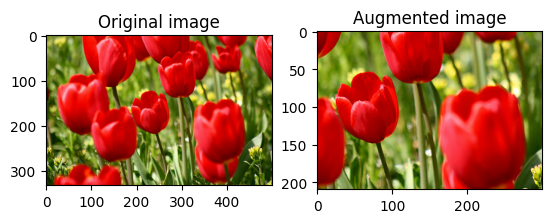

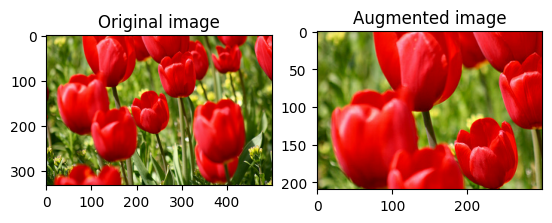

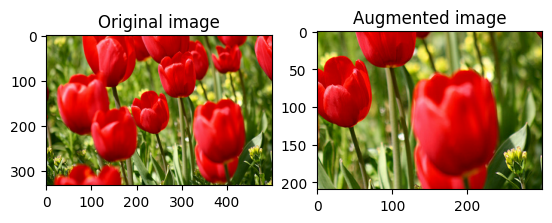

In [36]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_crop = tf.image.stateless_random_crop(
      image, size=[210, 300, 3], seed=seed)
  visualize(image, stateless_random_crop)

### 对数据集应用增强

我们首先再次下载图像数据集，以防它们在之前的部分中被修改。

In [37]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

接下来，定义一个用于调整图像大小和重新缩放图像的效用函数。此函数将用于统一数据集中图像的大小和比例：

In [38]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

我们同时定义 `augment` 函数，该函数可以将随机变换应用于图像。此函数将在下一步中用于数据集。

In [39]:
def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed.
  new_seed = tf.random.split(seed, num=1)[0, :]
  # Random crop back to the original size.
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

#### 选项 1：使用 tf.data.experimental.Counter

创建一个 `tf.data.experimental.Counter()` 对象（我们称之为 `counter`)，并使用 `(counter, counter)` `Dataset.zip` 数据集。这将确保数据集中的每个图像都与一个基于 `counter` 的唯一值（形状为 `(2,)`）相关联，稍后可以将其传递到 `augment` 函数，作为随机变换的 `seed` 值。

In [40]:
# Create a `Counter` object and `Dataset.zip` it together with the training set.
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


将 `augment` 函数映射到训练数据集：

In [41]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [42]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [43]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

#### 选项 2：使用 `tf.random.Generator`

- 创建一个具有初始 `seed` 值的 `tf.random.Generator` 对象。在同一个生成器对象上调用 `make_seeds` 函数会始终返回一个新的、唯一的 `seed` 值。
- 定义一个封装容器函数：1) 调用 `make_seeds` 函数；2) 将新生成的 `seed` 值传递给 `augment` 函数进行随机变换。

注：`tf.random.Generator` 对象会将 RNG 状态存储在 `tf.Variable` 中，这意味着它可以保存为[检查点](../../guide/checkpoint.ipynb)或以 [SavedModel](../../guide/saved_model.ipynb) 格式保存。有关详情，请参阅[随机数生成](../../guide/random_numbers.ipynb)。

In [44]:
# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

In [45]:
# Create a wrapper function for updating seeds.
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label

将封装容器函数 `f` 映射到训练数据集，并将 `resize_and_rescale` 函数映射到验证集和测试集：

In [46]:
train_ds = (
    train_datasets
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [47]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [48]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

这些数据集现在可以用于训练模型了，如前文所述。

## 后续步骤

本教程演示了使用 Keras 预处理层和 `tf.image` 进行数据增强。

- 要了解如何在模型中包含预处理层，请参阅[图像分类](classification.ipynb)教程。
- 您可能也有兴趣了解预处理层如何帮助您对文本进行分类，请参阅[基本文本分类](../keras/text_classification.ipynb)教程。
- 您可以在此<a>指南</a>中了解有关 <code>tf.data</code> 的更多信息，并且可以在[这里](../../guide/data_performance.ipynb)了解如何配置输入流水线以提高性能。